In [136]:
"""
dataset: 
ignoring labels 1, 3, and 4, retaining only labels 0 (background noise) and label 2 (target class). 
background noise (label 0) is downsampled to ensure it matches the number of samples with label 2 
split the dataset using torch.utils.data.random_split, into 80% for the training set, 10% for the test set, and 10% for the validation set
model:
loss function modified to (MSE) loss 
output: sums the spikes along time dimension 
visualize the internal activity 
"""

import torch
import numpy as np


# Load tensor
labels_tensor = torch.load("/Users/xiaoyuliu/Documents/school/capstone/tensors/labels_tensor.pt")
spikes_tensor = torch.load("/Users/xiaoyuliu/Documents/school/capstone/tensors/spike_data_tensor.pt")

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')


Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


/var/folders/kd/vt_v73sx4y5b36zjny3pbn380000gn/T/ipykernel_11547/1897070404.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels_tensor = torch.load("/Users/xiaoyuliu/

In [143]:
import torch
import numpy as np

class CCMKDataset(torch.utils.data.Dataset):
    def __init__(self, spikes_tensor, labels_tensor, target_label=2):
        self.spikes_tensor = spikes_tensor
        self.labels_tensor = labels_tensor
        self.target_label = target_label

        # Step 1: Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]

        # Convert the target label (2) to 1 (positive sample)
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Step 2: Downsample label 0 (background noise) to match the number of target samples (label 2 -> now 1)
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        
        # print samples
        #print(f"Number of label 0 samples before downsampling: {len(label_0_indices)}")
        #print(f"Number of label 1 samples (after converting target label 2 to 1): {len(label_1_indices)}")

        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False))
        selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False))

        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # print data after samples
        print(f"Number of downsampled label 0 samples: {len(selected_label_0_indices)}")
        print(f"Number of target label 1 samples: {len(selected_label_1_indices)}")
        print(f"Balanced dataset length: {len(balanced_indices)}")

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int())}")

    def __len__(self):
        return len(self.labels_tensor)

    def __getitem__(self, idx):
        return self.spikes_tensor[idx], self.labels_tensor[idx]

# Example usage:
dataset = CCMKDataset(spikes_tensor=spikes_tensor, labels_tensor=labels_tensor)


Number of downsampled label 0 samples: 1046
Number of target label 1 samples: 1046
Balanced dataset length: 2092
Filtered Labels distribution after processing: tensor([1046, 1046])


In [138]:
from sklearn.model_selection import train_test_split

# Get all data and labels (spike data and corresponding labels)
all_data = spikes_tensor
all_labels = labels_tensor

# Step 1: Split the dataset into training and a temporary set (20% for temp set)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    all_data, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Step 2: Split the temporary set into test and validation sets (50% each from the temp set)
test_data, val_data, test_labels, val_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)


# Step 4: Convert the split data into tensors (if required) and create datasets and dataloaders
train_dataset = CCMKDataset(spikes_tensor=train_data, labels_tensor=train_labels)
test_dataset = CCMKDataset(spikes_tensor=test_data, labels_tensor=test_labels)
val_dataset = CCMKDataset(spikes_tensor=val_data, labels_tensor=val_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)



In [139]:
# print the shape of the first sample in the dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check batch information in the dataloader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch


labels = torch.cat([batch[1] for batch in train_loader])
print(f'Labels distribution: {torch.bincount(labels.int())}')

Train dataset size: 1674
Test dataset size: 208
Validation dataset size: 210
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Labels distribution: tensor([837, 837])


In [147]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from rockpool.nn.networks import SynNet

# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # Number of output classes (assuming a binary classification task)
n_time = 101     # Number of time steps
batch_size = 32  # Batch size

# Initialize the SynNet model
net = SynNet(
    p_dropout = 0.1,                        # Dropout proportion to use
    #train_time_constants = True,            # Specify to train time constants
    #train_threshold = True,                 # Specify to train thresholds

    n_channels=n_channels,                # Number of input channels
    n_classes=n_classes,                  # Number of output classes (2 for binary classification)
    size_hidden_layers=[24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
)
#net.seq['0_neurons'].parameters()
print(net)




SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


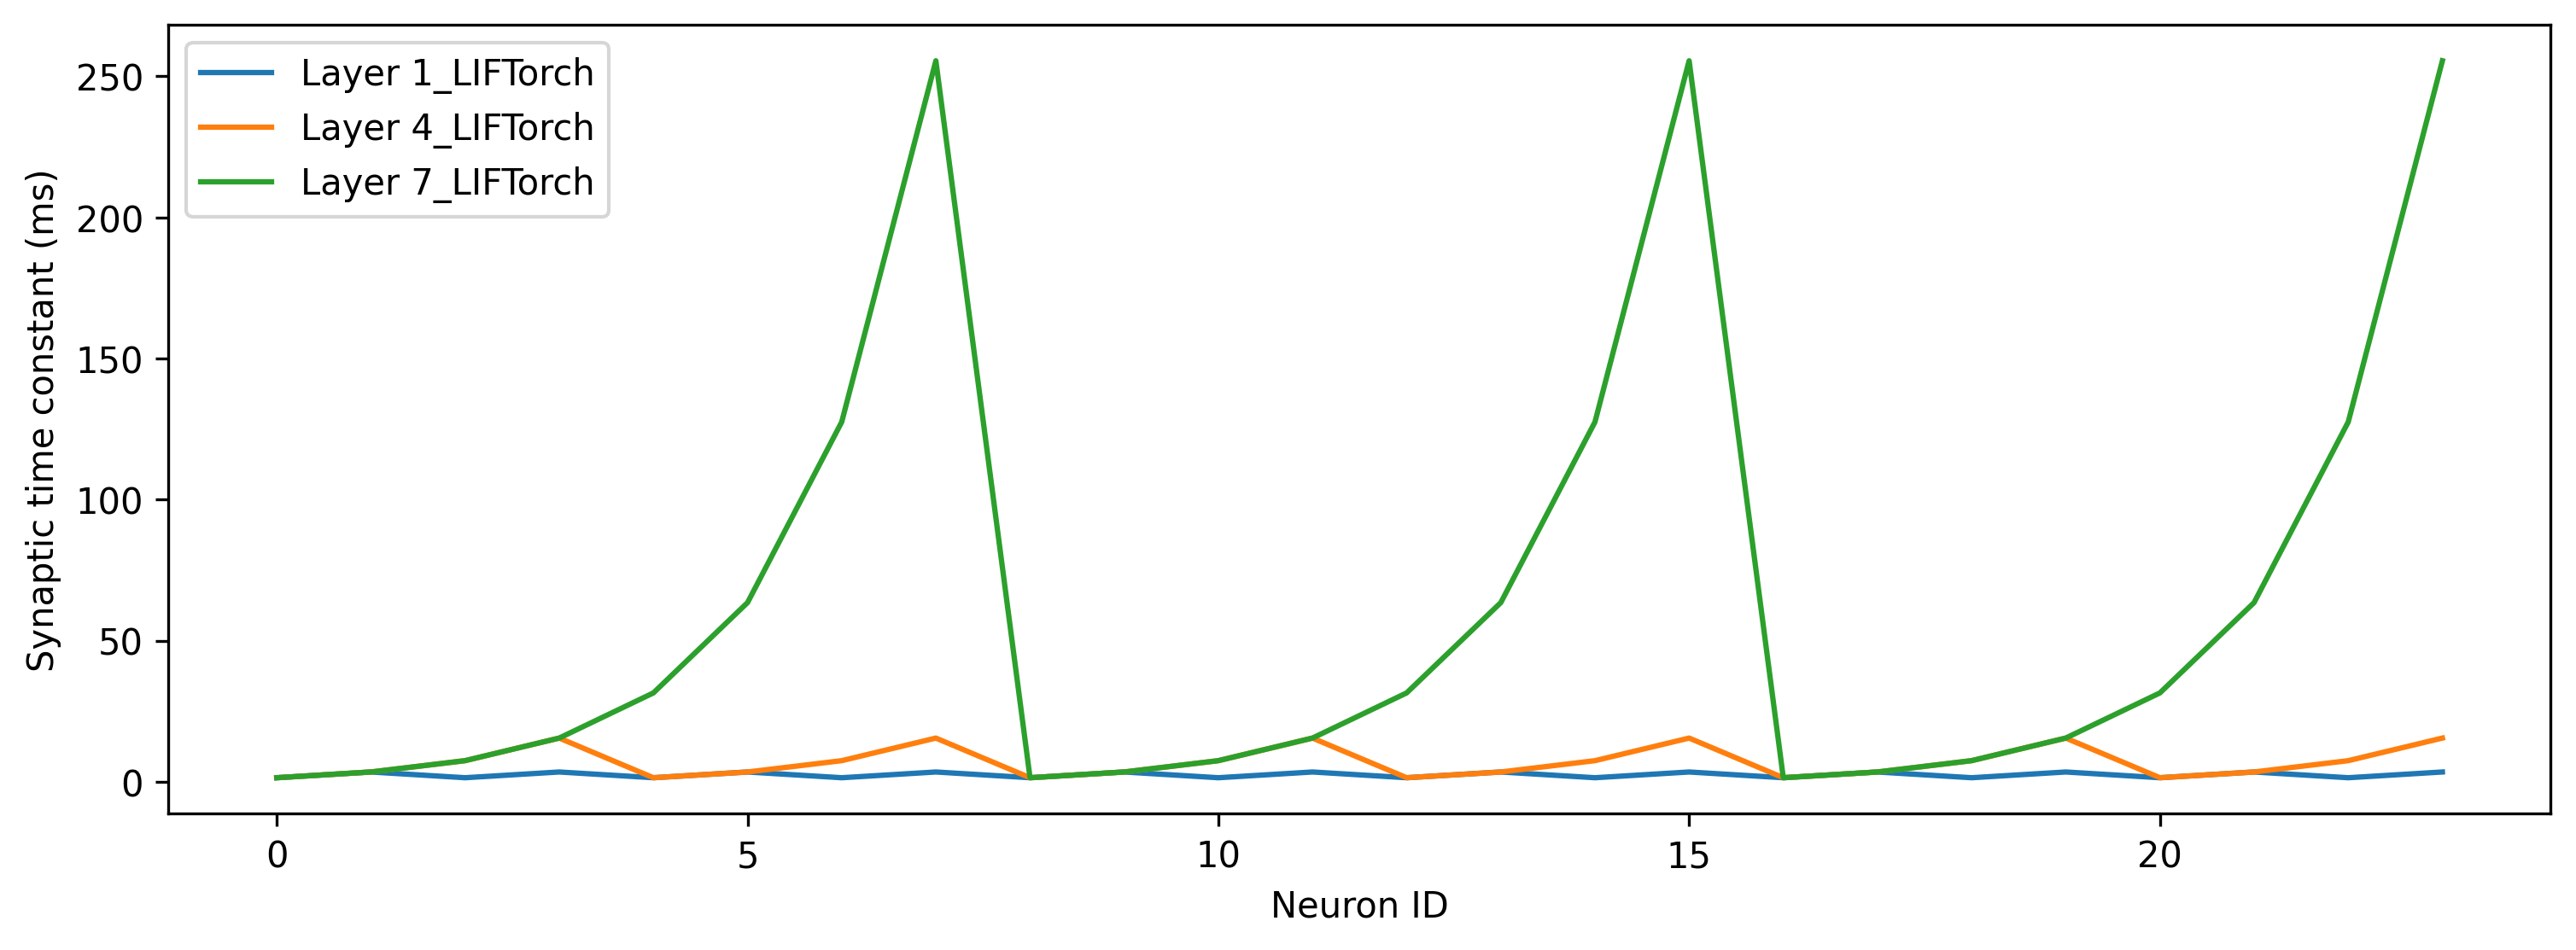

In [141]:

# - Import the matplotlib plotting library
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

# - Plot the synaptic time constants for each layer
for lyr in net.lif_names[:-1]:
    plt.plot(net.seq[lyr].tau_syn / 1e-3, label = f"Layer {lyr}")

plt.xlabel('Neuron ID')
plt.ylabel('Synaptic time constant (ms)')
plt.legend();

  3%|▎         | 1/30 [00:08<04:19,  8.96s/it]

Epoch 1, Loss: 7.65613207558416


  7%|▋         | 2/30 [00:17<03:59,  8.56s/it]

Epoch 2, Loss: 1.7510613208671786


 10%|█         | 3/30 [00:25<03:45,  8.35s/it]

Epoch 3, Loss: 1.2613207551668275


 13%|█▎        | 4/30 [00:33<03:35,  8.31s/it]

Epoch 4, Loss: 0.684198113263778


 17%|█▋        | 5/30 [00:41<03:25,  8.23s/it]

Epoch 5, Loss: 1.3172169811320755


 20%|██        | 6/30 [00:49<03:16,  8.19s/it]

Epoch 6, Loss: 1.3435141511683195


 23%|██▎       | 7/30 [00:57<03:07,  8.17s/it]

Epoch 7, Loss: 1.1658018872422993


 27%|██▋       | 8/30 [01:05<02:58,  8.11s/it]

Epoch 8, Loss: 1.1300707549419042


 30%|███       | 9/30 [01:13<02:49,  8.09s/it]

Epoch 9, Loss: 1.554245283018868


 33%|███▎      | 10/30 [01:21<02:41,  8.06s/it]

Epoch 10, Loss: 1.1629716981694382


 37%|███▋      | 11/30 [01:29<02:32,  8.04s/it]

Epoch 11, Loss: 1.4965801891290917


 40%|████      | 12/30 [01:38<02:24,  8.05s/it]

Epoch 12, Loss: 1.2924528301886793


 43%|████▎     | 13/30 [01:45<02:16,  8.02s/it]

Epoch 13, Loss: 0.9693396226415094


 47%|████▋     | 14/30 [01:54<02:08,  8.03s/it]

Epoch 14, Loss: 1.4810141510558579


 50%|█████     | 15/30 [02:02<02:00,  8.03s/it]

Epoch 15, Loss: 0.8112028297388328


 53%|█████▎    | 16/30 [02:10<01:53,  8.12s/it]

Epoch 16, Loss: 0.9159198110958315


 57%|█████▋    | 17/30 [02:18<01:44,  8.07s/it]

Epoch 17, Loss: 0.9656839623766126


 60%|██████    | 18/30 [02:26<01:36,  8.06s/it]

Epoch 18, Loss: 0.9265330197676173


 63%|██████▎   | 19/30 [02:34<01:29,  8.12s/it]

Epoch 19, Loss: 1.0647405661501974


 67%|██████▋   | 20/30 [02:44<01:25,  8.52s/it]

Epoch 20, Loss: 0.9615566038860465


 70%|███████   | 21/30 [02:58<01:32, 10.24s/it]

Epoch 21, Loss: 0.9510613207547169


 73%|███████▎  | 22/30 [05:03<05:58, 44.87s/it]

Epoch 22, Loss: 0.9531839624890741


 77%|███████▋  | 23/30 [06:11<06:02, 51.75s/it]

Epoch 23, Loss: 1.68584905705362


 80%|████████  | 24/30 [06:20<03:52, 38.70s/it]

Epoch 24, Loss: 3.1964622646007896


 83%|████████▎ | 25/30 [06:28<02:28, 29.68s/it]

Epoch 25, Loss: 0.5012971702611672


 87%|████████▋ | 26/30 [06:37<01:34, 23.51s/it]

Epoch 26, Loss: 0.9702830224666955


 90%|█████████ | 27/30 [06:47<00:58, 19.34s/it]

Epoch 27, Loss: 1.1280660381856955


 93%|█████████▎| 28/30 [06:55<00:32, 16.01s/it]

Epoch 28, Loss: 1.2547169811320755


 97%|█████████▋| 29/30 [07:03<00:13, 13.72s/it]

Epoch 29, Loss: 1.065448113207547


100%|██████████| 30/30 [07:12<00:00, 14.42s/it]

Epoch 30, Loss: 0.9771226419592803


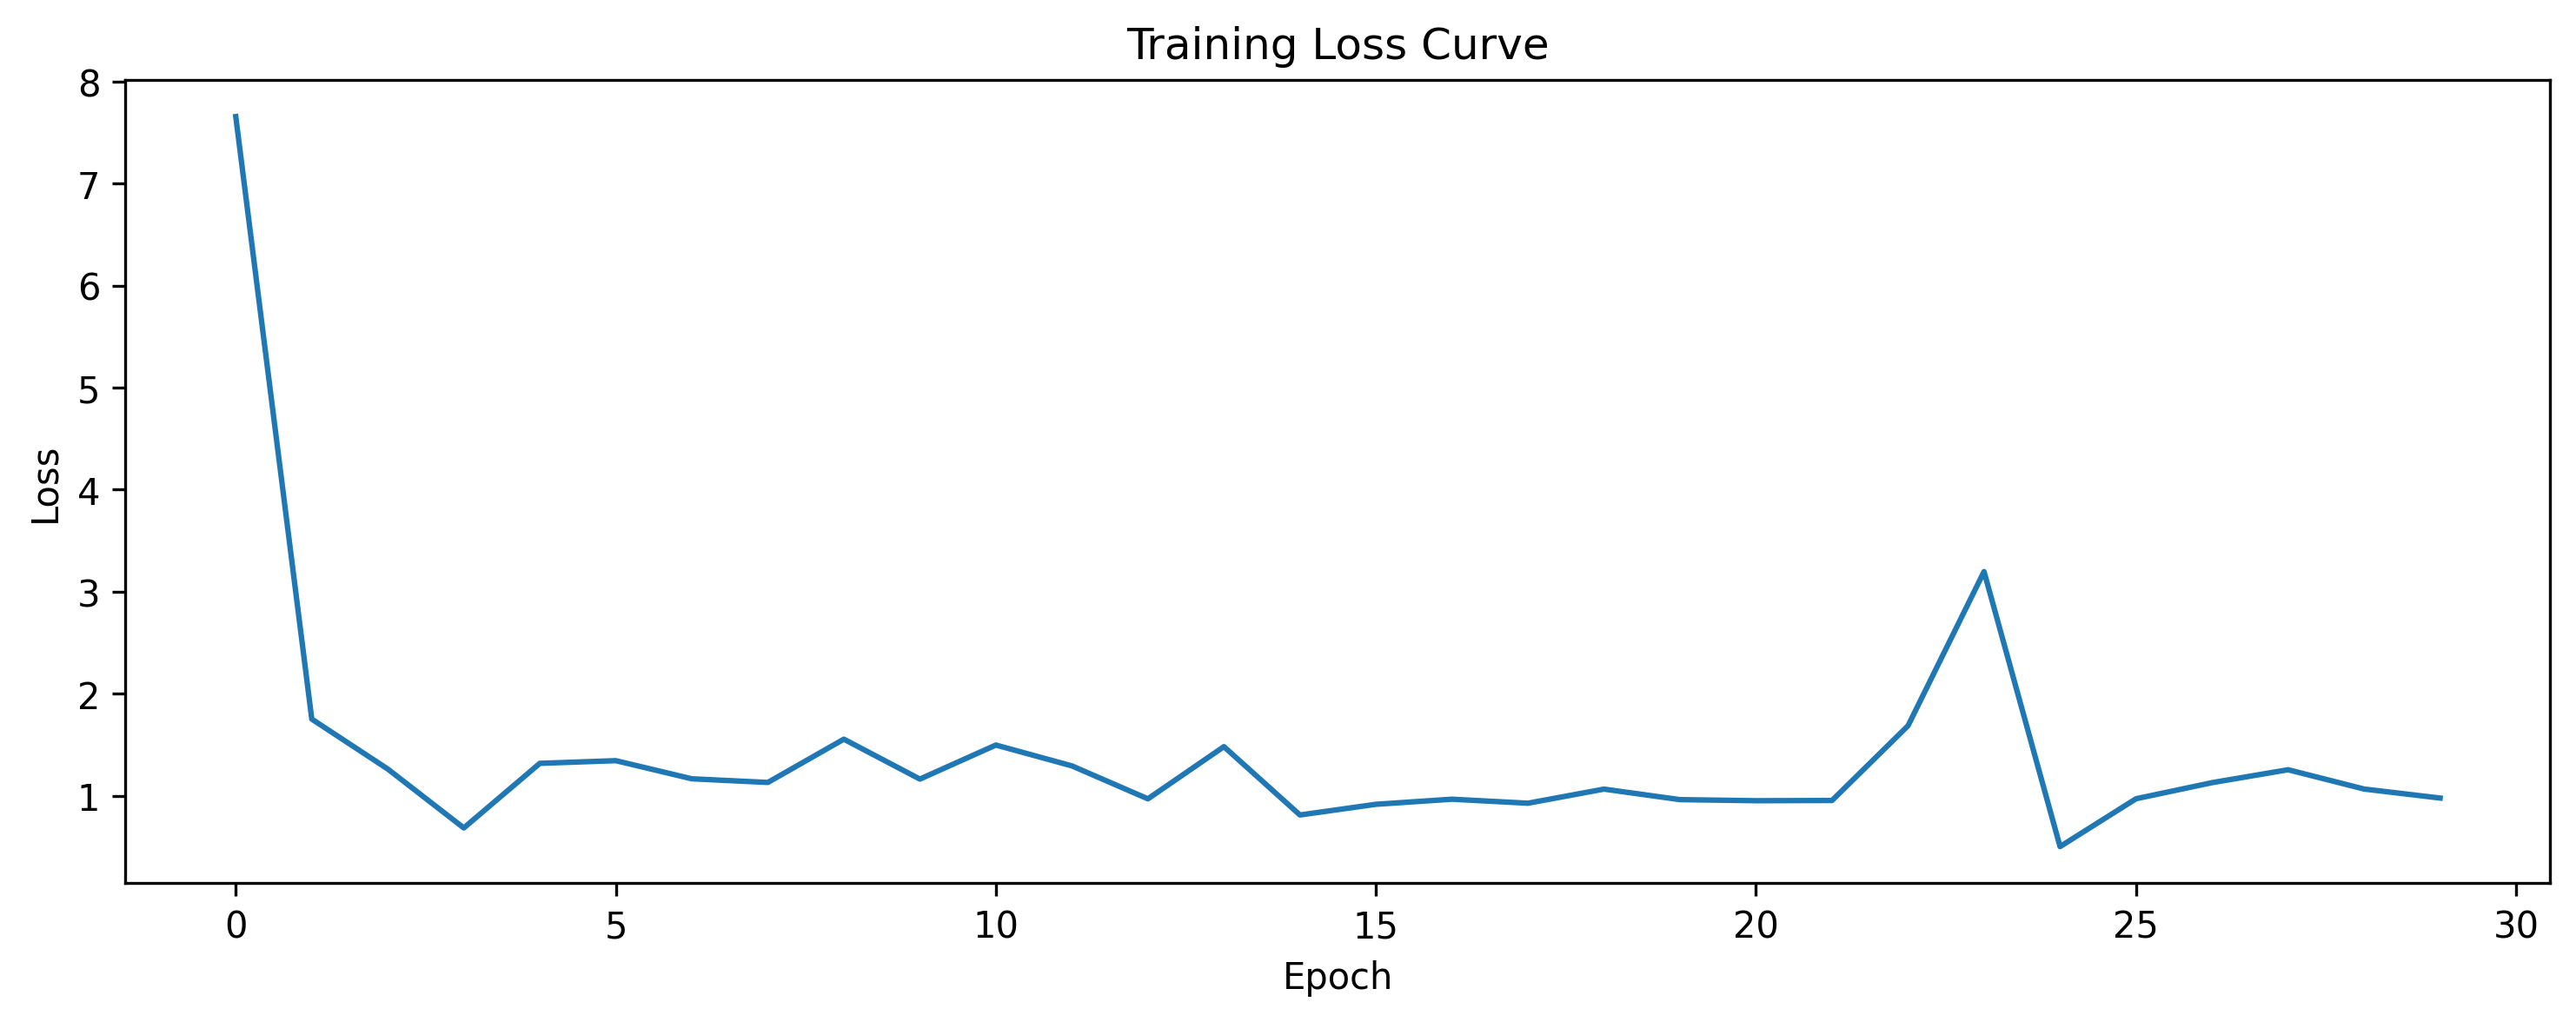

Training completed


In [148]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting loss curve
from tqdm import trange  # Import tqdm to display a progress bar during training

# Define the loss function and optimizer
optimizer = Adam(net.parameters().astorch(), lr=1e-3)  # Use Adam optimizer with a learning rate of 1e-3
loss_fun = MSELoss()  # Using MSE Loss as the loss function
n_epochs = 30  # Set the number of training epochs

# Create a list to store the loss for each epoch
losses = []

# Training loop
for epoch in trange(n_epochs):  # trange provides a progress bar for the epochs
    running_loss = 0.0  # Initialize running loss for the current epoch
    
    for inputs, targets in train_loader:  # Iterate through the training data
        optimizer.zero_grad()  # Clear any previously calculated gradients

        # Transpose the input tensor to match the expected shape [batch_size, n_time, n_channels]
        inputs = inputs.transpose(1, 2)  # Now the shape is [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = net(inputs)  # The output has the shape [batch_size, n_time, n_classes]

        # Sum the output over the time dimension, resulting in output shape [batch_size, n_classes]
        output = output.sum(dim=1)  # Sum spikes over the time dimension
        
        # Ensure targets are of float type, as expected by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization step
        loss.backward()  # Compute the gradients
        optimizer.step()  # Update the model parameters

        # Accumulate the loss for this batch
        running_loss += loss.item()

    # Calculate the average loss for the current epoch and append to the losses list
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    
    # Print average loss for the current epoch
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

# Plot the loss curve after training
plt.plot(losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Training completed')


# Training loop

In [158]:


# Define the loss function and optimizer
optimizer = Adam(net.parameters().astorch(), lr=1e-3)  # Use Adam optimizer with a learning rate of 1e-3
loss_fun = MSELoss()  # Using MSE Loss as the loss function
n_epochs = 30  # Set the number of training epochs

# Create a list to store the loss for each epoch
losses = []

# Training loop
for epoch in range(n_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0  # Initialize running loss for the current epoch
    
    for inputs, targets in train_loader:  # Iterate through the training data
        optimizer.zero_grad()  # Clear any previously calculated gradients

        # Adjust input dimensions to match model expectations
        # Check the input shape before transposing
        #print(f"Original input shape: {inputs.shape}")  # Print the shape for debugging

        # Transpose the input tensor to match the expected shape [batch_size, n_time, n_channels]
        inputs = inputs.transpose(1, 2)  # Now the shape is [batch_size, n_time, n_channels]
        
        # Print the input shape after transpose for debugging
        #print(f"Transposed input shape: {inputs.shape}")

        # Forward pass through the network
        output, _, _ = net(inputs)  # The output has the shape [batch_size, n_time, n_classes]

        # Sum the output over the time dimension, resulting in output shape [batch_size, n_classes]
        output = output.sum(dim=1)  # Sum spikes over the time dimension
        
        # Ensure targets are of float type, as expected by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization step
        loss.backward()  # Compute the gradients
        optimizer.step()  # Update the model parameters

        # Accumulate the loss for this batch
        running_loss += loss.item()

    # Calculate the average loss for the current epoch and append to the losses list
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    
    # Print average loss for the current epoch
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')


Epoch 1, Loss: 1.0753537736973673
Epoch 2, Loss: 0.8778301887917068
Epoch 3, Loss: 0.8583726410595875
Epoch 4, Loss: 0.9214622642634049
Epoch 5, Loss: 0.8088443397351031
Epoch 6, Loss: 0.8360849056603774
Epoch 7, Loss: 2.967452830301141
Epoch 8, Loss: 1.102004716981132
Epoch 9, Loss: 2.087853773584906
Epoch 10, Loss: 5.8650943400724875
Epoch 11, Loss: 0.5
Epoch 12, Loss: 3.4676886796951294
Epoch 13, Loss: 0.5012971702611672
Epoch 14, Loss: 315.86780660388604
Epoch 15, Loss: 0.4987028303011408
Epoch 16, Loss: 0.5012971702611672
Epoch 17, Loss: 0.4987028303011408
Epoch 18, Loss: 0.5012971702611672
Epoch 19, Loss: 0.5012971702611672
Epoch 20, Loss: 0.5025943393977184
Epoch 21, Loss: 0.5
Epoch 22, Loss: 0.4987028303011408
Epoch 23, Loss: 0.4974056606022817
Epoch 24, Loss: 0.5012971702611672
Epoch 25, Loss: 0.7357311248779297
Epoch 26, Loss: 0.8681603771335674
Epoch 27, Loss: 0.4974056606022817
Epoch 28, Loss: 0.90459905705362
Epoch 29, Loss: 1.6030660378483106
Epoch 30, Loss: 0.50365566082

# Loss Curve Plot

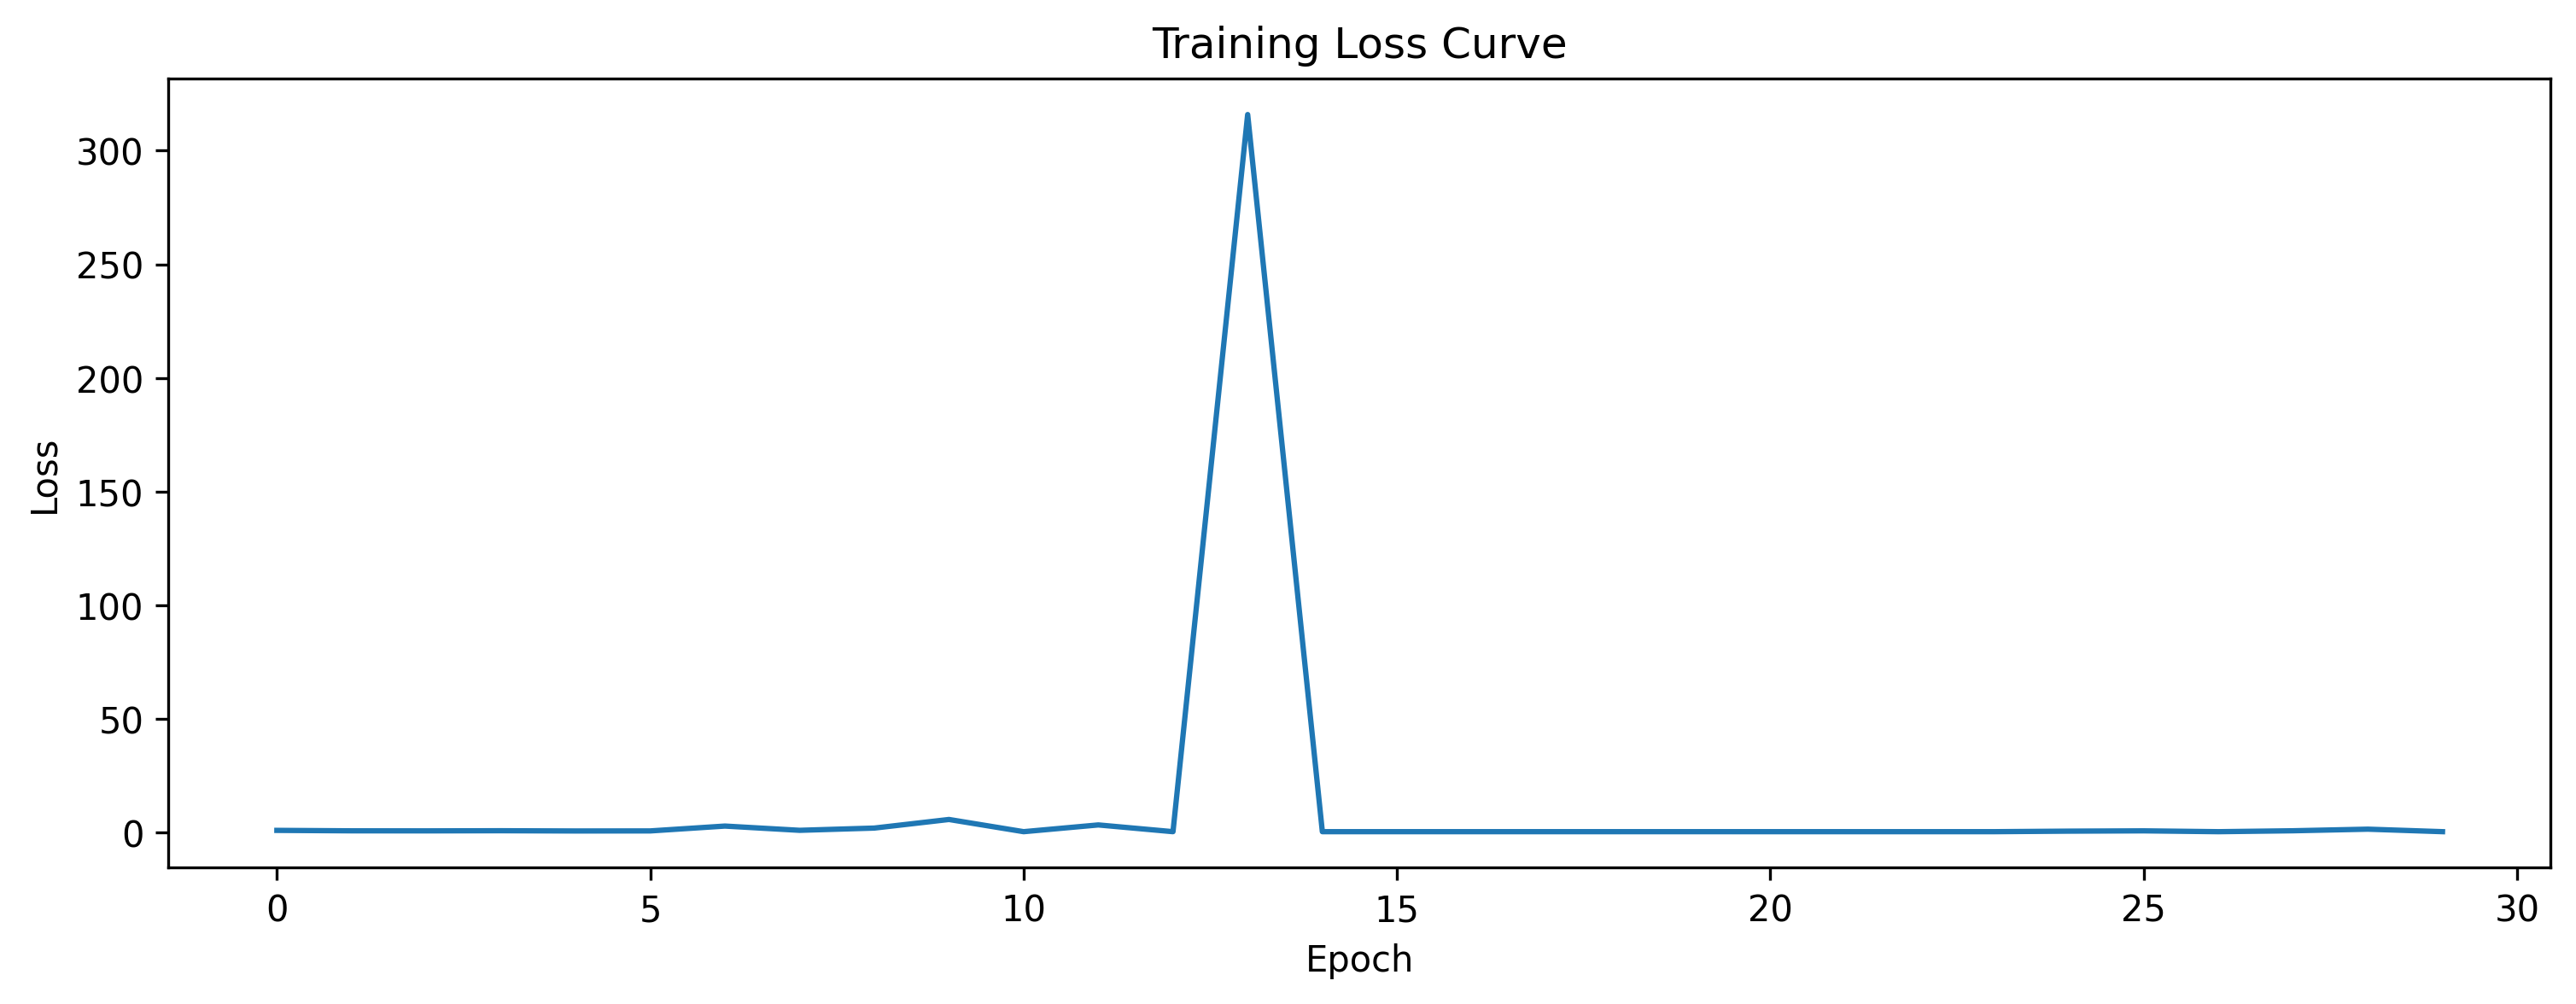

In [159]:
# Plot the loss curve after training

import matplotlib.pyplot as plt

# Plot the loss curve after training
plt.plot(losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualize Single Intermediate Activations

Activation from 0_LinearTorch:  torch.Size([1, 101, 24])
Activation from 1_LIFTorch:  torch.Size([1, 101, 24])
Activation from 3_LinearTorch:  torch.Size([1, 101, 24])


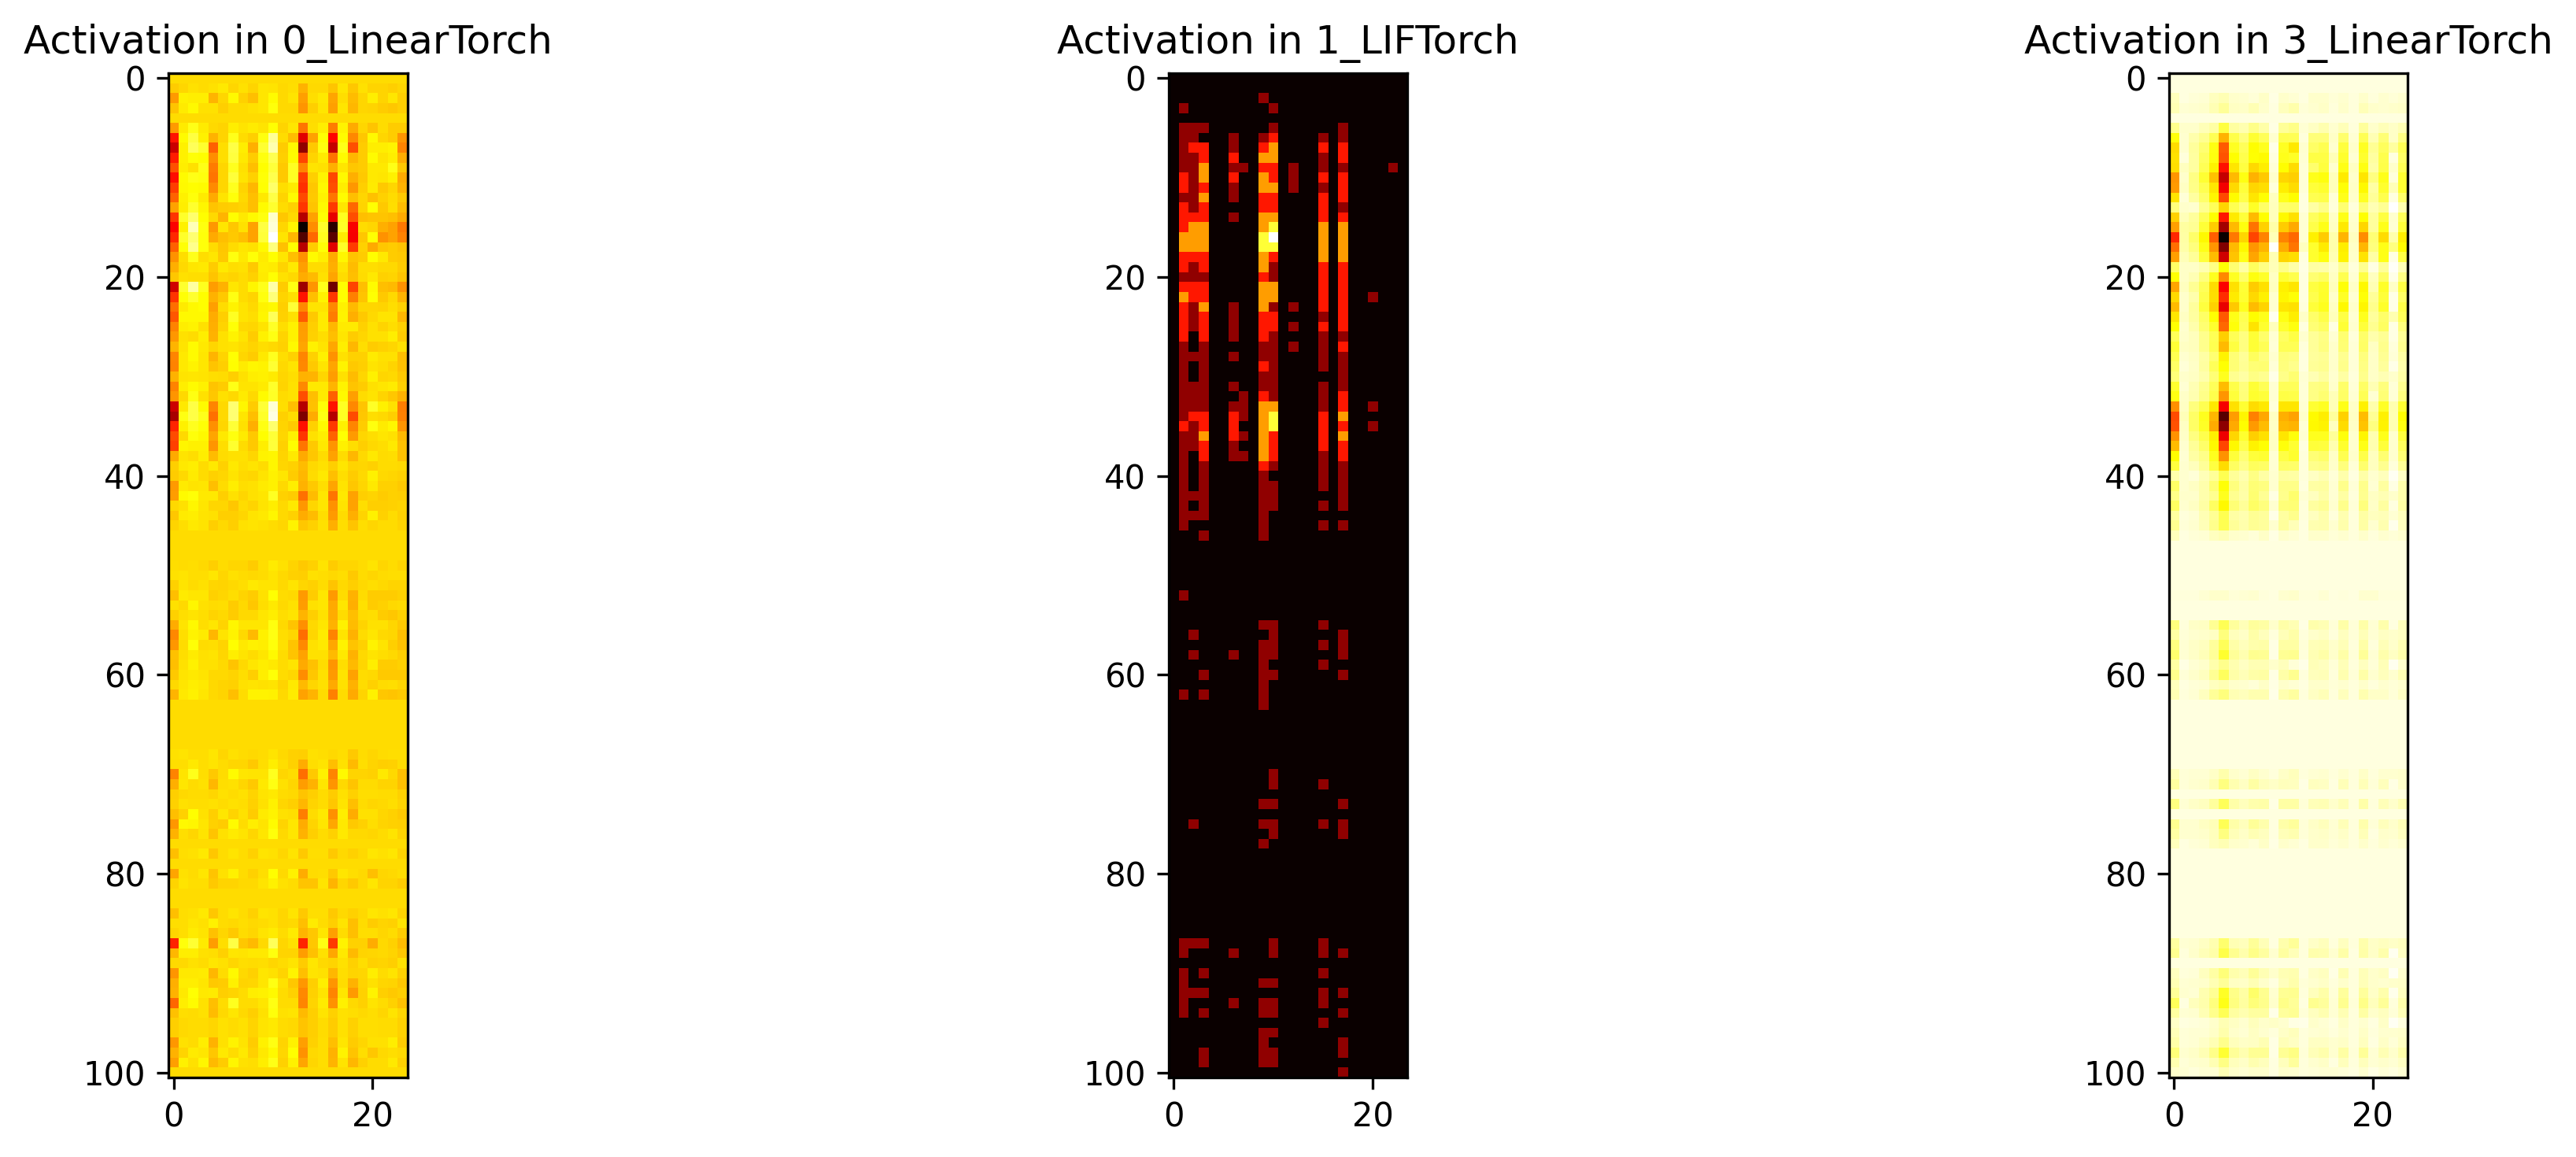

In [161]:
# Testing a single sample to visualize intermediate activations

# Dictionary to store activations
activations = {}

# Define a hook to capture the output of a specific layer
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()  # Save the output without gradients
    return hook

# Register the hook to layers inside 'seq'
net.seq[0].register_forward_hook(get_activation('0_LinearTorch'))  # First Linear layer
net.seq[1].register_forward_hook(get_activation('1_LIFTorch'))  # First LIF layer
net.seq[3].register_forward_hook(get_activation('3_LinearTorch'))  # Second Linear layer

# Testing a single sample
inputs, target = next(iter(train_loader))  # Get a batch of data
single_input = inputs[0].unsqueeze(0)  # Select a single sample and add batch dimension

# Adjust the single input's dimensions (transpose) before forwarding through the network
single_input = single_input.transpose(1, 2)  # Ensure input has shape [batch_size, n_time, n_channels]

# Forward pass
net(single_input)

# Visualize the activation of a specific layer
# Print activation shapes for each registered layer
print("Activation from 0_LinearTorch: ", activations['0_LinearTorch'].shape)
print("Activation from 1_LIFTorch: ", activations['1_LIFTorch'].shape)
print("Activation from 3_LinearTorch: ", activations['3_LinearTorch'].shape)

# Example: Visualize activations of the first neuron in each layer

# Plot activation for 0_LinearTorch
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(activations['0_LinearTorch'][0].cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title('Activation in 0_LinearTorch')

# Plot activation for 1_LIFTorch
plt.subplot(1, 3, 2)
plt.imshow(activations['1_LIFTorch'][0].cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title('Activation in 1_LIFTorch')

# Plot activation for 3_LinearTorch
plt.subplot(1, 3, 3)
plt.imshow(activations['3_LinearTorch'][0].cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title('Activation in 3_LinearTorch')

plt.tight_layout()
plt.show()

